**Jupyter Kernel**:

* If you are in SageMaker Notebook instance, please make sure you are using **conda_pytorch_latest_p36** kernel
* If you are on SageMaker Studio, please make sure you are using **SageMaker JumpStart PyTorch 1.0** kernel

**Run All**:

* If you are in SageMaker notebook instance, you can go to *Cell tab -> Run All*
* If you are in SageMaker Studio, you can go to *Run tab -> Run All Cells*

## Training our Classifier from scratch

Depending on an application, sometimes image classification is enough. In this notebook, we see how to train and deploy an accurate classifier from scratch on **NEU-CLS** dataset

In [1]:
import json

import numpy as np

import sagemaker
from sagemaker.s3 import S3Downloader

sagemaker_session = sagemaker.Session()
sagemaker_config = json.load(open("../stack_outputs.json"))
role = sagemaker_config["IamRole"]
solution_bucket = sagemaker_config["SolutionS3Bucket"]
region = sagemaker_config["AWSRegion"]
solution_name = sagemaker_config["SolutionName"]
bucket = sagemaker_config["S3Bucket"]

First, we download our **NEU-CLS** dataset from our public S3 bucket

In [2]:
from sagemaker.s3 import S3Downloader

original_bucket = f"s3://{solution_bucket}-{region}/{solution_name}"
original_data = f"{original_bucket}/data/NEU-CLS.zip"
original_sources = f"{original_bucket}/build/lib/source_dir.tar.gz"
print("original data: ")
S3Downloader.list(original_data)

original data: 


['s3://sagemaker-solutions-prod-ap-northeast-2/sagemaker-defect-detection/1.3.0/data/NEU-CLS.zip']

For easiler data processing, depending on the dataset, we unify the class and label names using the scripts from `prepare_data`

In [3]:
%%time
RAW_DATA_PATH= !echo $PWD/raw_neu_cls
RAW_DATA_PATH = RAW_DATA_PATH.n
DATA_PATH = !echo $PWD/neu_cls
DATA_PATH = DATA_PATH.n

!mkdir -p $RAW_DATA_PATH
!aws s3 cp $original_data $RAW_DATA_PATH

!mkdir -p $DATA_PATH
!python ../src/prepare_data/neu.py $RAW_DATA_PATH/NEU-CLS.zip $DATA_PATH

download: s3://sagemaker-solutions-prod-ap-northeast-2/sagemaker-defect-detection/1.3.0/data/NEU-CLS.zip to raw_neu_cls/NEU-CLS.zip
Traceback (most recent call last):
  File "../src/prepare_data/neu.py", line 118, in <module>
    main(sys.argv[1], sys.argv[2])
  File "../src/prepare_data/neu.py", line 96, in main
    cp_class_images(data_path, cls_, cls_path)
  File "../src/prepare_data/neu.py", line 41, in cp_class_images
    assert len(lst) == len(list(class_path_dest.glob("*")))
AssertionError
CPU times: user 737 ms, sys: 207 ms, total: 944 ms
Wall time: 48 s


After data preparation, we need to setup some paths that will be used throughtout the notebook

In [4]:
prefix = "neu-cls"
neu_cls_s3 = f"s3://{bucket}/{prefix}"
sources = f"{neu_cls_s3}/code/"
train_output = f"{neu_cls_s3}/output/"
neu_cls_prepared_s3 = f"{neu_cls_s3}/data/"
!aws s3 sync $DATA_PATH $neu_cls_prepared_s3 --quiet # remove the --quiet flag to view sync outputs
s3_checkpoint = f"{neu_cls_s3}/checkpoint/"
sm_local_checkpoint_dir = "/opt/ml/checkpoints/"
!aws s3 cp $original_sources $sources

copy: s3://sagemaker-solutions-prod-ap-northeast-2/sagemaker-defect-detection/1.3.0/build/lib/source_dir.tar.gz to s3://sagemaker-soln-dfd-js-y8hzob-937800239079-ap-northeast-2/neu-cls/code/source_dir.tar.gz


## Visualization

Let examine some datasets that we will use later by providing an `ID`

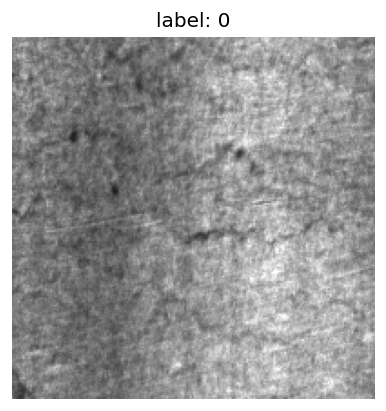

In [5]:
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np
import torch
from PIL import Image
from torch.utils.data import DataLoader

try:
    import sagemaker_defect_detection
except ImportError:
    import sys
    from pathlib import Path

    ROOT = Path("../src").resolve()
    sys.path.insert(0, str(ROOT))

from sagemaker_defect_detection import NEUCLS

def visualize(image, label, predicted=None):
    if not isinstance(image, Image.Image):
        image = Image.fromarray(image)

    plt.figure(dpi=120)
    if predicted is not None:
        plt.title(f"label: {label}, prediction: {predicted}")
    else:
        plt.title(f"label: {label}")

    plt.axis("off")
    plt.imshow(image)
    return


dataset = NEUCLS(DATA_PATH, split="train")
ID = 0
assert 0 <= ID <= 300
image, label = dataset[ID]
visualize(image, label)

We train our model with `resnet34` backbone for **50 epochs** and obtains about **99%** test accuracy, f1-score, precision and recall as follows

In [ ]:
%%time
import logging
from os import path as osp

from sagemaker.pytorch import PyTorch

NUM_CLASSES = 6
BACKBONE = "resnet34"
assert BACKBONE in [
    "resnet34",
    "resnet50",
], "either resnet34 or resnet50. Make sure to be consistent with model_fn in classifier.py"
EPOCHS = 50
SEED = 123

hyperparameters = {
    "backbone": BACKBONE,
    "num-classes": NUM_CLASSES,
    "epochs": EPOCHS,
    "seed": SEED,
}

assert not isinstance(sagemaker_session, sagemaker.LocalSession), "local session as share memory cannot be altered"

model = PyTorch(
    entry_point="classifier.py",
    source_dir=osp.join(sources, "source_dir.tar.gz"),
    role=role,
    train_instance_count=1,
    train_instance_type="ml.g4dn.2xlarge",
    hyperparameters=hyperparameters,
    py_version="py3",
    framework_version="1.5",
    sagemaker_session=sagemaker_session,  # Note: Do not use local session as share memory cannot be altered
    output_path=train_output,
    checkpoint_s3_uri=s3_checkpoint,
    checkpoint_local_path=sm_local_checkpoint_dir,
    # container_log_level=logging.DEBUG,
)

model.fit(neu_cls_prepared_s3)

Then, we deploy our model which takes about **8 minutes** to complete

In [ ]:
%%time
predictor = model.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.xlarge",
    endpoint_name=sagemaker_config["SolutionPrefix"] + "-classification-endpoint",
)

## Inference

We are ready to test our model by providing some test data and compare the actual labels with the predicted one

In [ ]:
from sagemaker_defect_detection import get_transform
from sagemaker_defect_detection.utils.visualize import unnormalize_to_hwc

ID = 100
assert 0 <= ID <= 300
test_dataset = NEUCLS(DATA_PATH, split="test", transform=get_transform("test"), seed=SEED)
image, label = test_dataset[ID]

outputs = predictor.predict(image.unsqueeze(0).numpy())
_, predicted = torch.max(torch.from_numpy(np.array(outputs)), 1)

image_unnorm = unnormalize_to_hwc(image)
visualize(image_unnorm, label, predicted.item())

## Optional: Delete the endpoint and model

When you are done with the endpoint, you should clean it up.

All of the training jobs, models and endpoints we created can be viewed through the SageMaker console of your AWS account.

In [ ]:
predictor.delete_model()
predictor.delete_endpoint()